<h3>ETL#1</h3>
This is the initial notebook for the ETL task. The original 3m+ record count csv is going to be read, explored, and transformed. It won't be the final dataframe but it will be a good initial step and provide the csv files to load into the SQLite db in the ETL#2 notebook.

In [124]:
#Imports
import pandas as pd
import datetime as datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import pyproj

In [125]:
#pull in the original doc from https://data.world/carlvlewis/u-s-weather-outliers-1964
#The original file has over 3 million rows, I trimmed it down in order to abide by the git size limits so please make sure you use the original instead of replacing it with the Git version. 
file_path = "data/weather-anomalies-1964-2013.csv"
file_df = pd.read_csv(file_path)

<h3>Separating our data</h3>

In [126]:
stations = file_df[['id', 'station_name', 'longitude', 'latitude']]
stations = stations.drop_duplicates('id')

In [127]:
weather = file_df[['serialid', 'id', 'date_str','degrees_from_mean','max_temp','min_temp','type']]

In [128]:
#convert string to date in order to filter by year.
weather['date_str'] = pd.to_datetime(weather['date_str'])

C:\Users\ecreg\AppData\Local\Temp\ipykernel_10320\77618501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['date_str'] = pd.to_datetime(weather['date_str'])


In [129]:
#Create the year column in order to easily filter out years and potential groupby data.
weather['year'] = weather['date_str'].dt.year

C:\Users\ecreg\AppData\Local\Temp\ipykernel_10320\2751927833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['year'] = weather['date_str'].dt.year


In [130]:
#Export of the weather anomaly records from the trimmed original (due to size limits)
weather.to_csv('data/weather.csv', index=False)

In [131]:
#Checking the count of datapoints for each station over the original dataset, there are some issues here. 
weather.groupby(['id','year']).count().sort_values('serialid', ascending=False)

,,serialid,date_str,degrees_from_mean,max_temp,min_temp,type
id,year,,,,,,
USC00513099,1989,233,233,233,233,233,233
USW00022536,1981,167,167,167,167,167,167
RQC00666073,2012,163,163,163,163,163,163
RQC00660158,1967,139,139,139,139,139,139
VQW00011624,1972,131,131,131,131,131,131
...,...,...,...,...,...,...,...
USC00308248,2001,1,1,1,1,1,1
USW00026514,1991,1,1,1,1,1,1
USC00101956,1995,1,1,1,1,1,1


<h3>Data Exploration</h3>
Let's confirm the hunch that the NOAA data is entirely in the US or if it includes it's territories. Then transform the data using geopandas.

In [132]:
# df_geo = gpd.GeoDataFrame(stations, geometry = gpd.points_from_xy(stations.longitude, stations.latitude))
Projection = pyproj.CRS.from_user_input("EPSG:4269")
df_points = gpd.GeoDataFrame(stations, geometry = gpd.points_from_xy(stations.longitude, stations.latitude, crs=Projection))

<Axes: >

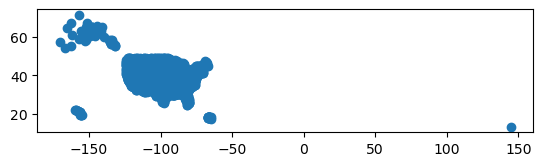

In [133]:
#Confirmation that locations are in US or US territories.
df_points.plot()

In [134]:
#Importing a shapefile provided by NWS of all states and territories for analysis. https://www.weather.gov/gis/USStates
# I also had to limit the original USA file,hence the "cut". This is due to size limits on Git. 
USA = gpd.read_file('data/USAcut.shp')
#Trimming Down the USA shapefile to just NC.
USA[USA['STATE']=='NC'].to_file('data/NC.shp')
NC = gpd.read_file('data/NC.shp')

In [135]:
#Coordinate check of shapefile
NC.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

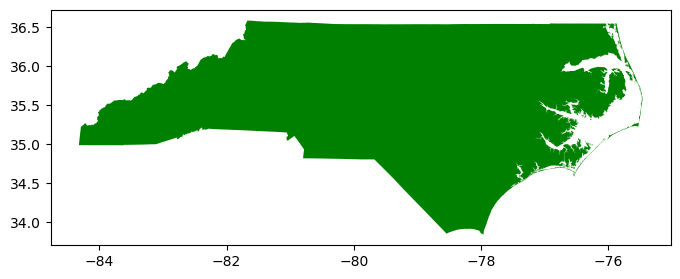

In [136]:
#Plot check of shapefile
NC.plot(figsize=(8,8), color = "green")

<Axes: >

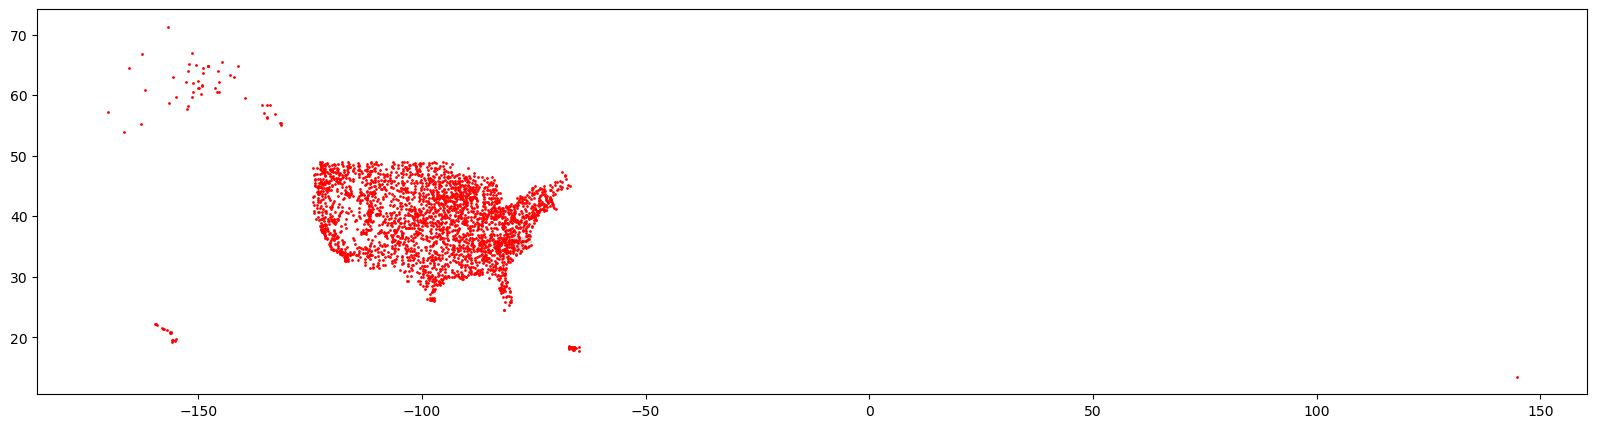

In [137]:
#Overlay of the stations and NC shp
fig, ax = plt.subplots(figsize=(20,20))
NC.plot(ax=ax, color='lightgrey')
df_points.plot(ax=ax, color='red', markersize = 1 )

In [138]:
#Spatial join of the station data with the NWS shapefile to pull in states for each station.
df_join = gpd.sjoin(df_points, NC, how='inner', predicate='within')

In [139]:
df_join

,id,station_name,longitude,latitude,geometry,index_right,STATE,NAME,FIPS,LON,LAT
324,USC00319357,WHITEVILLE 7 NW,-78.7914,34.4094,POINT (-78.79140 34.40940),0,NC,North Carolina,37,-79.37865,35.54369
334,USC00316853,PLYMOUTH 5 E,-76.6592,35.8722,POINT (-76.65920 35.87220),0,NC,North Carolina,37,-79.37865,35.54369
335,USW00093729,CAPE HATTERAS AP,-75.6219,35.2325,POINT (-75.62190 35.23250),0,NC,North Carolina,37,-79.37865,35.54369
337,USC00318500,TARBORO 1 S,-77.5386,35.8847,POINT (-77.53860 35.88470),0,NC,North Carolina,37,-79.37865,35.54369
384,USW00013754,CHERRY POINT MCAS,-76.8833,34.9000,POINT (-76.88330 34.90000),0,NC,North Carolina,37,-79.37865,35.54369
...,...,...,...,...,...,...,...,...,...,...,...
7493,USC00314860,LAURINBURG,-79.4664,34.7508,POINT (-79.46640 34.75080),0,NC,North Carolina,37,-79.37865,35.54369
13057,USC00314055,HIGHLANDS,-83.1983,35.0567,POINT (-83.19830 35.05670),0,NC,North Carolina,37,-79.37865,35.54369
47285,USC00312837,ENKA,-82.6531,35.5406,POINT (-82.65310 35.54060),0,NC,North Carolina,37,-79.37865,35.54369
67515,USC00316349,OCRACOKE,-75.9872,35.1075,POINT (-75.98720 35.10750),0,NC,North Carolina,37,-79.37865,35.54369


<Axes: >

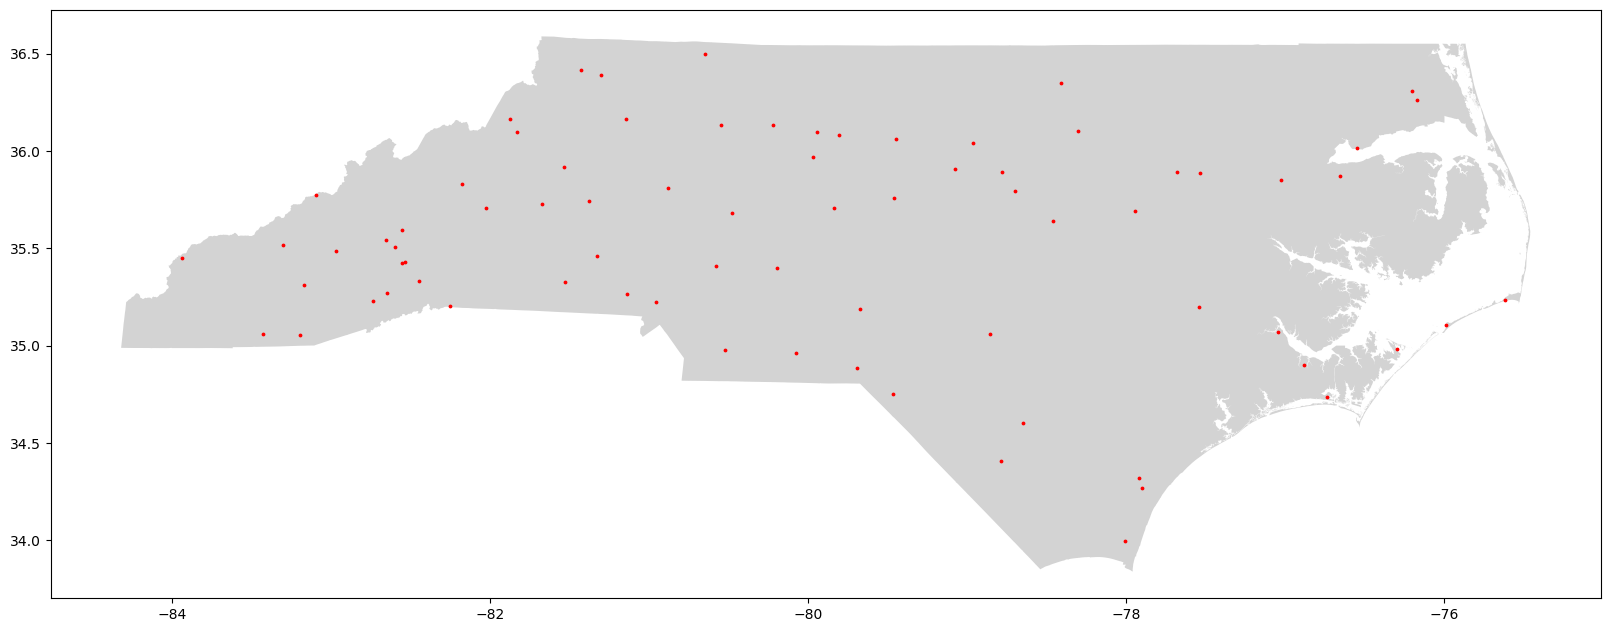

In [140]:
#Overlay of the NC stations and NC shp
fig, ax = plt.subplots(figsize=(20,20))
NC.plot(ax=ax, color='lightgrey')
df_join.plot(ax=ax, color='red', markersize = 3 )

In [141]:
#Lets keep all columns except the eroded centerpoints of the polygons
stations_df = df_join.drop(['LON', 'LAT'], axis=1)
stations_df

,id,station_name,longitude,latitude,geometry,index_right,STATE,NAME,FIPS
324,USC00319357,WHITEVILLE 7 NW,-78.7914,34.4094,POINT (-78.79140 34.40940),0,NC,North Carolina,37
334,USC00316853,PLYMOUTH 5 E,-76.6592,35.8722,POINT (-76.65920 35.87220),0,NC,North Carolina,37
335,USW00093729,CAPE HATTERAS AP,-75.6219,35.2325,POINT (-75.62190 35.23250),0,NC,North Carolina,37
337,USC00318500,TARBORO 1 S,-77.5386,35.8847,POINT (-77.53860 35.88470),0,NC,North Carolina,37
384,USW00013754,CHERRY POINT MCAS,-76.8833,34.9000,POINT (-76.88330 34.90000),0,NC,North Carolina,37
...,...,...,...,...,...,...,...,...,...
7493,USC00314860,LAURINBURG,-79.4664,34.7508,POINT (-79.46640 34.75080),0,NC,North Carolina,37
13057,USC00314055,HIGHLANDS,-83.1983,35.0567,POINT (-83.19830 35.05670),0,NC,North Carolina,37
47285,USC00312837,ENKA,-82.6531,35.5406,POINT (-82.65310 35.54060),0,NC,North Carolina,37
67515,USC00316349,OCRACOKE,-75.9872,35.1075,POINT (-75.98720 35.10750),0,NC,North Carolina,37


In [142]:
#Export of transformed stations data (NC ONLY)
stations_df.to_csv('data/stations.csv', index=False)

<h2>ETL#2: Creation of the SQLite database</h2>
This code will be used to create our sqlite database. 

In [143]:
# loading the dependencies
import pandas as pd
from pathlib import Path
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt


In [144]:
Path('data/Analysis.db').touch()

In [145]:
conn = sqlite3.connect('data/Analysis.db')
c=conn.cursor()

Credit to https://mungingdata.com/sqlite/create-database-load-csv-python/ for guidance on initial execute function and syntax.

In [146]:
# Initial creation of the database tables for 'Analysis db'
c.execute('''CREATE TABLE stations (
    id varchar(100) NOT NULL PRIMARY KEY,
    station_name varchar(100) NOT NULL,
    longitude numeric(7,4) NOT NULL,
    latitude numeric(7,4) NOT NULL,
    STATE varchar(100) NOT NULL,
    NAME varchar(100) NOT NULL,
    FIPS numeric(2,0) NOT NULL
)''')

c.execute('''CREATE TABLE weather (
    serialid int NOT NULL,
    id varchar(100) NOT NULL,
    date_str date NOT NULL,
    degrees_from_mean numeric(5,2) NOT NULL,
    max_temp numeric(4,1) NOT NULL,
    min_temp numeric(4,1) NOT NULL,
    type varchar(100) NOT NULL,
    CONSTRAINT pk_weather PRIMARY KEY (serialid, id),
    CONSTRAINT fk_weather_id FOREIGN KEY(id) REFERENCES stations(id)
)''')


In [147]:
#Creation of stations table to house the location and name of stations.
stations = pd.read_csv('data/stations.csv')
stations.to_sql('stations', conn, if_exists='replace', index = False)

76

In [148]:
#Creation of weather table to house daily recorded weather activities.
weather = pd.read_csv('data/weather.csv')
weather.to_sql('weather', conn, if_exists='replace', index=False)

3196832

In [149]:
#JOIN function outside of pandas as required by deliverable 2
c.execute('''CREATE TABLE data AS
    SELECT w.serialid, w.id, w.date_str, w.degrees_from_mean, w.max_temp, w.min_temp, w.type, w.year, 
    s.station_name, s.longitude, s.latitude, s.STATE, s.NAME, s.FIPS 
    FROM weather w 
    INNER JOIN stations s 
    USING (id)''')